Nama : Diggy Bani Nusantara; Kelas : Belajar Machine Learning Untuk Pemula; No. Registrasi : 1494037162101-336; Program : FGA; Model Machine Learning dengan Time Series;

In [1]:
#Library
from google.colab import files

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import matplotlib.pyplot as plt

In [2]:
#Dataset
!pip install -q Kaggle

uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d berkeleyearth/climate-change-earth-surface-temperature-data

Saving kaggle.json to kaggle.json
100% 84.7M/84.7M [00:04<00:00, 23.9MB/s]
100% 84.7M/84.7M [00:04<00:00, 18.7MB/s]


In [3]:
#Unzip Dataset
!unzip climate-change-earth-surface-temperature-data.zip -d train

Archive:  climate-change-earth-surface-temperature-data.zip
  inflating: train/GlobalLandTemperaturesByCity.csv  
  inflating: train/GlobalLandTemperaturesByCountry.csv  
  inflating: train/GlobalLandTemperaturesByMajorCity.csv  
  inflating: train/GlobalLandTemperaturesByState.csv  
  inflating: train/GlobalTemperatures.csv  


In [4]:
#Dataset Location
data_train = pd.read_csv('/content/train/GlobalLandTemperaturesByCountry.csv')
data_train.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [5]:
#Dataset Climate Change Range From 1980 to 2010
data_train['dt'] = pd.to_datetime(data_train['dt'])  
get_data = (data_train['dt'] > '1980-01-01') & (data_train['dt'] <= '2010-01-01')
data_train.loc[get_data]

data_train = data_train.loc[get_data]
display(data_train)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
2835,1980-02-01,-6.484,0.441,Åland
2836,1980-03-01,-3.947,0.466,Åland
2837,1980-04-01,2.928,0.597,Åland
2838,1980-05-01,6.154,0.241,Åland
2839,1980-06-01,13.999,0.642,Åland
...,...,...,...,...
577413,2009-09-01,22.831,0.329,Zimbabwe
577414,2009-10-01,24.544,0.429,Zimbabwe
577415,2009-11-01,23.886,0.421,Zimbabwe
577416,2009-12-01,24.731,0.430,Zimbabwe


In [6]:
#Checking Null/NaN
data_train.isnull().sum()

dt                                 0
AverageTemperature               360
AverageTemperatureUncertainty      0
Country                            0
dtype: int64

In [7]:
#Drop Null/NaN Column
data_train.dropna(subset=['AverageTemperature'],inplace=True)
data_train.dropna(subset=['AverageTemperatureUncertainty'],inplace=True)
data_train.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64

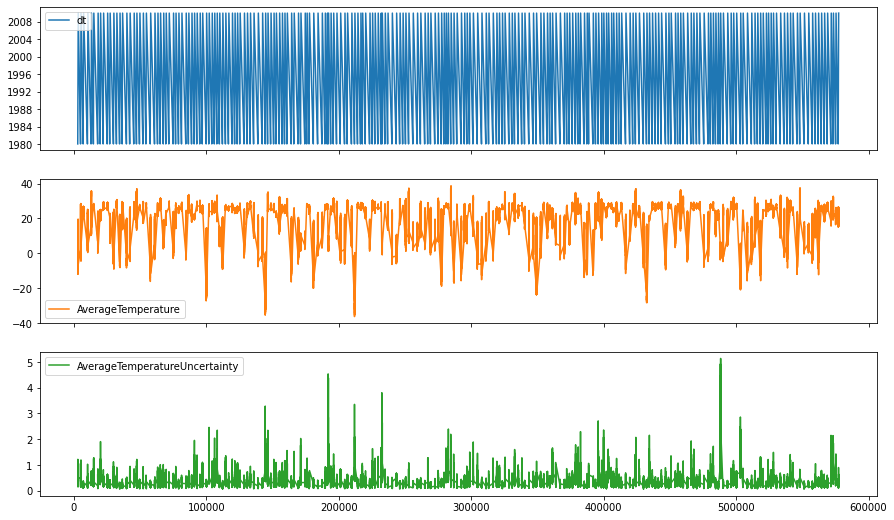

In [8]:
#Plot Each Column
data_train_plot = data_train
data_train_plot[data_train_plot.columns.to_list()].plot(subplots=True, figsize=(15, 9))
plt.show()

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
Country                                  object
dtype: object

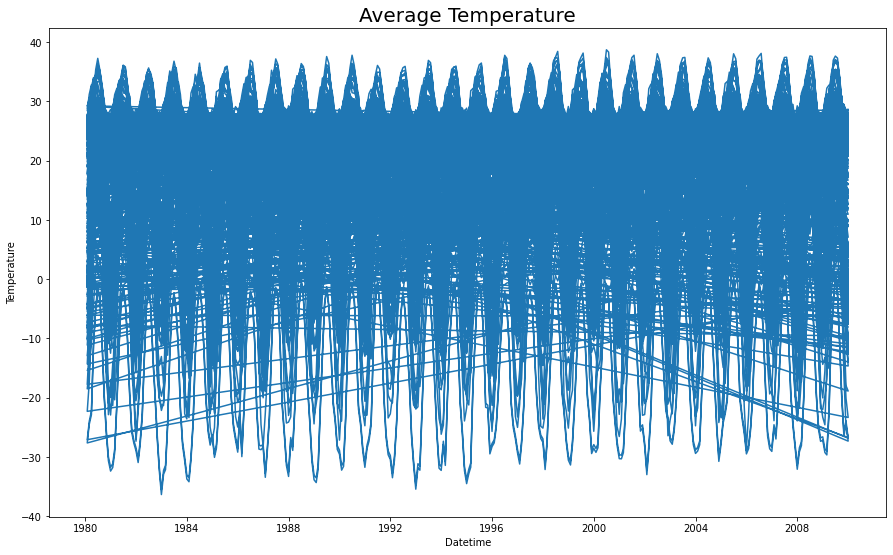

In [9]:
#Plot Dates and Average Temperature
dates = data_train['dt'].values
temp = data_train['AverageTemperature'].values

dates = np.array(dates)
temp = np.array(temp)

plt.figure(figsize=(15,9))
plt.plot(dates, temp)

plt.title('Average Temperature', fontsize = 20)
plt.ylabel('Temperature')
plt.xlabel('Datetime')

data_train.dtypes

In [10]:
#Split Dataset
x_train, x_valid, y_train, y_valid = train_test_split(temp, dates, train_size=0.8, test_size = 0.2, shuffle = False )

#Total Data Train and Validation
print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_valid))

Total Data Train :  69696
Total Data Validation :  17424


In [11]:
#Change Dataset Type/Format for Modelling
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
#Sequential Model
tf.keras.backend.set_floatx('float64')

train_set = windowed_dataset(x_train, window_size=64, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=64, batch_size=200, shuffle_buffer=1000)
model = Sequential([
    LSTM(60, return_sequences=True),
    LSTM(60),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])

In [13]:
#Callback Mae
Mae = (data_train['AverageTemperature'].max() - data_train['AverageTemperature'].min()) * 10/100
print(Mae)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<2.4 and logs.get('val_mae')<2.4):
      print("\nMAE Telah Mencapai < 10%")
      self.model.stop_training = True
callbacks = myCallback()

7.503700000000001


In [14]:
#Learning Rate SGD for Optimizer
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

#Compile
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=50, validation_data = val_set, callbacks=[callbacks])

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


      6/Unknown - 9s 89ms/step - loss: 16.9454 - mae: 17.4417

349/349 [==============================] - 37s 80ms/step - loss: 17.5510 - mae: 18.0476 - val_loss: 11.6492 - val_mae: 12.1439
Epoch 2/50
349/349 [==============================] - 26s 75ms/step - loss: 4.9891 - mae: 5.4538 - val_loss: 3.6360 - val_mae: 4.0901
Epoch 3/50
349/349 [==============================] - 27s 76ms/step - loss: 3.5301 - mae: 3.9794 - val_loss: 3.5661 - val_mae: 4.0269
Epoch 4/50
349/349 [==============================] - 26s 74ms/step - loss: 3.3921 - mae: 3.8382 - val_loss: 3.3159 - val_mae: 3.7623
Epoch 5/50
349/349 [==============================] - 30s 84ms/step - loss: 3.2717 - mae: 3.7161 - val_loss: 3.1842 - val_mae: 3.6310
Epoch 6/50
349/349 [==============================] - 26s 75ms/step - loss: 3.0831 - mae: 3.5235 - val_loss: 2.9610 - val_mae: 3.4058
Epoch 7/50
349/349 [==============================] - 27s 76ms/step - loss: 2.7928 - mae: 3.2299 - val_loss: 2.6272 - val_mae: 3.0777
Epoch 8/50
349/349 [==============================] - 27s 76ms/step -

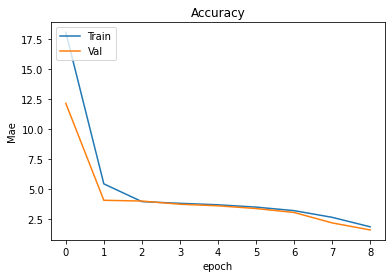

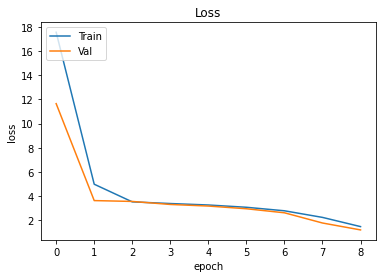

In [15]:
#Plot Accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Accuracy')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()